# **GM(1,1) & 马尔可夫链 轨道交通流量预测**
<br>
<hr>

### 2.1 导入相关的包

In [28]:
import os
import sklearn
import warnings
import copy
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

warnings.filterwarnings('ignore')
%matplotlib inline

#### 2.2.1 读取数据  

In [2]:
file_dir = './data'
csv_files = os.listdir(file_dir)
print(csv_files)

['cpc.csv', 'cpm.csv', 'passengerFlow.csv']


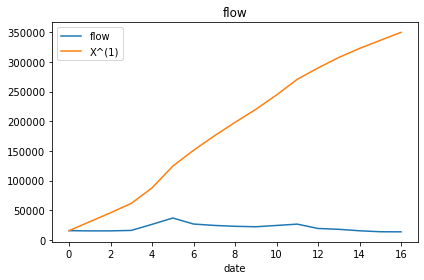

In [76]:
# df 作为最后输出的 DataFrame 初始化为空
df = pd.DataFrame()
feature = 'passengerFlow'
infix = feature + '.csv'
path = os.path.join(file_dir, infix)
df = pd.read_csv(path)
df['X^(1)'] = df.flow.cumsum()
# 获取 df 数据信息
# df.info()
# df.describe()
# 按照时间轴绘制 cpc 和 cpm 指标数据
df.plot(kind='line', x='date', title='flow')
# df.plot(kind='line', x='date', y='flow', title='flow', color='g')
# df.plot(kind='line', x='date', y='X^(1)', title='flow', color='g')
plt.tight_layout();

灰色预测法不适用


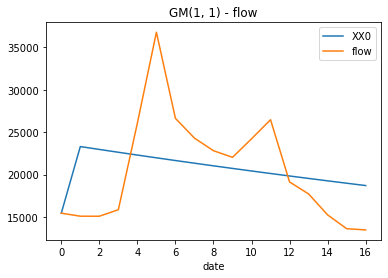

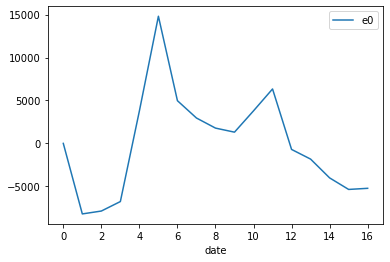

In [82]:
n = len(df['date'])
X0 = df['flow'].values
X1 = df['X^(1)'].values
B = np.zeros([n-1,2])
Y = np.zeros([n-1,1])
for i in range(0,n-1):
    B[i][0] = -0.5*(X1[i] + X1[i+1])
    B[i][1] = 1
    Y[i][0] = X0[i+1]

#计算GM(1,1)微分方程的参数a和u
A = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Y)
a = A[0][0]
u = A[1][0]

#建立灰色预测模型
XX1 = np.zeros(n)
XX1[0] = X0[0]
for i in range(1,n):
    XX1[i] = (X0[0] - u/a)*(math.exp(-a * i)) + u/a

XX0 = np.zeros(n)
XX0[0] = X0[0]
for i in range(1,n):
    XX0[i] = XX1[i] - XX1[i - 1]

df['XX0'] = XX0
df.plot(kind='line', x='date', y=['XX0', 'flow'], title='GM(1, 1) - flow')

e0 = np.zeros(n)
#模型精度的后验差检验
e = 0      #求残差平均值
for i in range(0,n):
    e0[i] = X0[i] - XX0[i]
    e += e0[i]
e /= n
df['e0'] = e0
df.plot(kind='line', x='date', y=['e0'], title='')

#求历史数据平均值
aver = 0;     
for i in range(0,n):
    aver += X0[i]
aver /= n

#求历史数据方差
s12 = 0;     
for i in range(0,n):
    s12 += (X0[i]-aver)**2
s12 /= n

#求残差方差
s22 = 0;       
for i in range(0,n):
    s22 += ((X0[i] - XX0[i]) - e)**2
s22 /= n

#求后验差比值
C = s22 / s12   

#求小误差概率
cout = 0
for i in range(0,n):
    if abs((X0[i] - XX0[i]) - e) < 0.6754*math.sqrt(s12):
        cout = cout+1
    else:
        cout = cout
P = cout / n

if (C < 0.35 and P > 0.95):
    #预测精度为一级
    m = 10   #请输入需要预测的年数
    #print('往后m各年负荷为：')
    f = np.zeros(m)
    for i in range(0,m):
        f[i] = (X0[0] - u/a)*(1-math.exp(a))*math.exp(-a*(i+n))    
else:
    print('灰色预测法不适用')

7


<AxesSubplot:title={'center':'e^0'}, xlabel='date'>

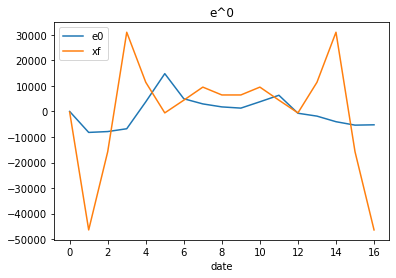

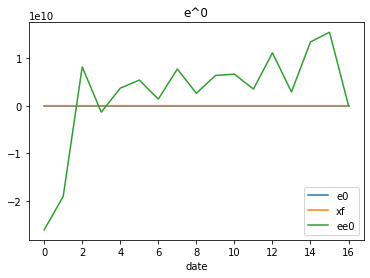

In [73]:
xf = np.fft.fft(e0)   # 对离散数据e0做fft变换得到变换之后的数据xf
df['xf'] = xf
df.plot(kind='line', x='date', y=['e0', 'xf'], title='e^0')

N = int(n - 1)
if N % 2 == 0:
    v = int(N / 2 - 1)
else:
    v = int((N - 1) / 2 - 1)
print(v)
p = np.zeros((N, 2*v + 1))
for i in range(0, n-1):
    p[i][0] = 0.5
for i in range(0, n-1):
    for j in range(1, 2*v + 1):
        if j % 2 == 0:
            p[i][j] = sym.cos(j / 2 * 2 * sym.pi * (i / N))
        else:
            p[i][j] = sym.sin(j / 2 * 2 * sym.pi * (i / N))
c = np.linalg.inv(p.T.dot(p)).dot(p.T).dot(e0[:N])
# c

ee0 = np.zeros(n)
for i in range(0, n-1):
    ee0[i] += 0.5 * c[0]
    for j in range(1, v):
        k = 1
        ee0[i] += (c[k]*sym.cos(2*j*sym.pi*i / N) + c[k+1]*sym.sin(2*j*sym.pi*i / N))
        k = k + 2
df['ee0'] = ee0
df.plot(kind='line', x='date', y=['e0', 'xf', 'ee0'], title='e^0')

Fx: 4*sin(x)/pi + 4*sin(3*x)/(3*pi) + 4*sin(5*x)/(5*pi) + 4*sin(7*x)/(7*pi)


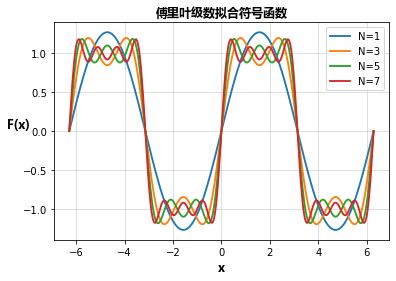

In [42]:
""" 傅里叶级数"""
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

N = 8  # 拟合的阶数

L = sym.pi  # 周期的一半
n, x = sym.symbols('n x')  # 创建符号

fx = sym.sign(x)  # 创建符号表达式 即要进行傅里叶级数分解的函数， 这里采用的是 符号函数


a0 = (1/(2*L))*sym.integrate(fx, (x, -L, L))
an = (1/L)*sym.integrate(fx*sym.cos((n*sym.pi*x)/(L)), (x, -L, L))
bn = (1/L)*sym.integrate(fx*sym.sin((n*sym.pi*x)/(L)), (x, -L, L))
xf = np.fft.fft(a0)

a = []
b = []
a.append(a0)
b.append(0)

for i in range(1, N):
    a.append(an.subs(n, i))
    b.append(bn.subs(n, i))


# 绘图 x轴范围设置
t = np.linspace(-2*np.pi, 2*np.pi, 256, endpoint=True)

Fx = a0
for i in range(1, N):
    if a[i] == 0 and b[i] == 0:
        continue
    
    # 累加 计算 Fx
    Fx = Fx + a[i]*sym.cos((i*sym.pi*x)/(L)) + b[i]*sym.sin((i*sym.pi*x)/(L))

    # 绘图使用
    y = []
    for j in t:
        y.append(Fx.subs(x, j))

    plt.plot(t, y, linewidth=0.5*(10-j), label='N={}'.format(i))


# 打印输出 各项的系数 以及 傅里叶级数表达式
# print('an:', a)
# print('bn:', b)
print('Fx:',Fx)


# 设置 图像字体信息
img_font = {'family': 'Microsoft YaHei',
            'size': 12,
            'weight': 'bold',
            }

# 图像显示设置
plt.legend(loc='upper right')
plt.title("傅里叶级数拟合符号函数", fontproperties=img_font)
plt.xlabel("x", fontproperties=img_font)
plt.ylabel("F(x)", fontproperties=img_font, rotation=360)
plt.grid(alpha=0.5)

plt.show()